## Artificial Neural Networks (ANN) 

An Artificial Neural Network is an interconnected group of nodes like the vast number of neurons in a brain. 


In [2]:
# Import the required packages
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [56]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://ecee.colorado.edu/~ecen4831/lectures/MLPnet.gif")

Here, each circular node represents an artificial neuron and an arrow represents a connection from the output of one neuron to the input of another. An ANN is built from nodes stacked in layers between the feature(input) vector and the target(output) vector.

A node in a neural network is built from weights and Activation function. 

An early version of the network built on one node is the perceptron. It takes a vector of real valued inputs, calculates a linear combination of these inputs, then outputs a 1 if the result is greater than some threshold and -1 otherwise.

         O(x1,x2,.....xn) =  1 if w0 + w1x1 + w2x2 + ...... wnxn > 0  
                          = -1  otherwise

Here w0,w1,w2,.......wn are the weights that determines the contribution of input xi and w0 is the threshold. The funcion o(x1,x2,.....xn) is the activation function. The goal is to learn the weights by training from examples so that it can be used for a binary classification problem. 


In [57]:
# A Perceptron unit 
Image(url= "http://i.stack.imgur.com/KUvpQ.png")

Single perceptrons can only express linear decision surfaces. Hence we need a network of these neurons. A Perceptron Network can be designed to have multiple layers, leading to the Multi-Layer Perceptron (aka MLP). 

There are many types of activation functions: 
1. Linear unit (unthresholded perceptron)
2. Sigmoid 
3. Hyperbolic Tangent(tanh) 
4. Rectified Linear Activation

In [58]:
# A sigmoid unit as an activation function
Image(url= "http://jmvidal.cse.sc.edu/talks/ann/ann-sigmoid.png",width=500, height=300)

For this tutorial, let’s build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data. The number of nodes in the output layer is determined by the number of classes - 1 ( 1 in our case as we only have 2 classes, we can put one output node predicting 0 or 1). 

We can choose the dimensionality (the number of nodes) of the hidden layer. The more nodes we put into the hidden layer the more complex functions we will be able to fit. But higher dimensionality comes at a cost. First, more computation is required to make predictions and learn the network parameters. A bigger number of parameters also means we become more prone to overfitting our data.

The weights are usually trained by BackPropagation algorithm that uses Gradient Descent which leads to a minimum error hypothesis (not necessarily Global minimum).  

To use Gradient Descent we need to have a differentiable threshold unit. For this tutorial, we will be using Sigmoid that can represent non linear decision surfaces. 


In [59]:
Image(url= "http://www.texample.net/media/tikz/examples/PNG/neural-network.png",width=500, height=300)

Let's start by generating a dataset. Scikit-Learn has useful dataset generators like the make_moons which can be used to learn non linear functions or decision boundaries using a neural network.

Below, we generate 400 data points which belong to any of the 2 classes (0 or 1). They are shown in different colors as blue and red. The feautures are x and y coordinates which are fed into the network and the ouput will be a probability for the point to belong to class 1

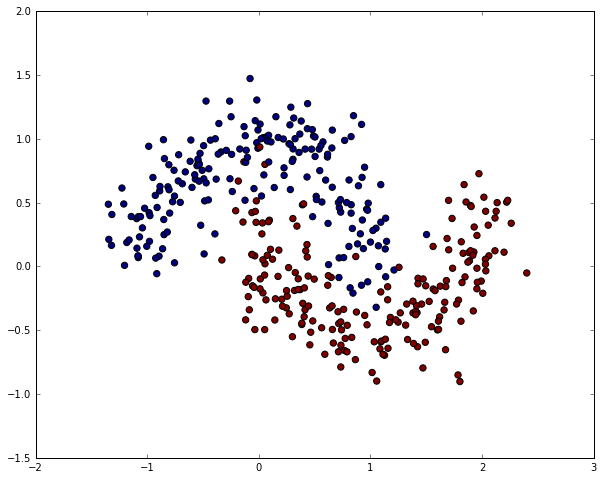

In [3]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(400, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y)

In backpropagation, we choose the loss function as the squared error (which is summed over all the outputs of the network), that we try to minimize. The gradient descent can be applied in 2 ways which are Stochastic (incremental) or Batch. For this tutorial, we implement a Stochastic gradient descent where weights are updated incrementally, after looking at each training example. In the batch GD, the weights are updated only after observing all the examples. 

When updating weights, we also add a momentum term which is basically the previous iteration's weight change multiplied with some factor. The purpose of adding this is to prevent from getting stuck in a local minima. 

### Back Propagation Algorithm

The __init__ function of the class ANN does the following: 
1. Creat a feed-forward network with 'n_inputs' inputs , 'n_hidden' hidden units and 'n_outputs' output units.
2. Initialize 'hidden_weights' and 'outer_weights' to small random numbers 
3. Initialize the 'hidden_momentum' and 'outer_momentum' to zeros

Now, let's understand how the method back_propagate works :

1. Propagates the input forward through the network: 
  * Appends a 1.0 (threshold) to the inputs and this is propagated forward through the network to compute the output of every unit in the network. First the hidden_outputs (sigmoids of the dot product of weights and inputs)  are calculated and then these are fed as inputs to the output layer neurons. (Note that we add a threshold 1.0 again to these hidden outputs) 

2. Propagates the errors backword through the network:
  * For each network output unit calculate the error term as (truth - outer_outputs) and then calculate delta as Outputs * (1 - outputs ) * error (Note that Outputs * (1 - outputs) is the sigmoid derivative of the outputs) 
  * For each hidden unit calculate error as dot product of outer_weights and outer_deltas and now calculate delta as hidden_outputs * ( 1 - hidden_outputs) * hidden_error   
  * Update hidden layer weights by computing the hidden_change as dot product of hidden_inputs and hidden_deltas and then multiplying it with some learning rate and also adding momentum which is basically the previous weight change multiplied by some  factor.
  * Similarly update output layer weights by computing the outer_change as dot product of outer_inputs and outer_deltas and then multiplying it with some learning rate and also adding momentum like above.

3. Repeat the above step 2 for each training example until the termination condition is met which in our case is the number of iterations (say 100) 

In [101]:
# Sigmoid function
def sigmoid(x,deriv=False):
    if(deriv):
        return x*(1-x)
    return 1/(1+np.exp(-x))

In [120]:
class ANN:
    def __init__(self, n_inputs, n_hidden, n_outputs):
        # initialising number of inputs, hidden and ouput nodes
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        
        # Create weights for hidden layer and outer layer neurons
        self.hidden_weights = 0.2*np.random.random((n_inputs + 1, n_hidden)) - 0.1
        self.outer_weights = 0.2*np.random.random((n_hidden + 1, n_outputs)) - 0.1   
        
        # initialize momentum
        self.hidden_momentum = np.zeros((n_inputs + 1, n_hidden))
        self.outer_momentum = np.zeros((n_hidden + 1, n_outputs))
        
    def back_propagate(self, inputs, truth, alpha, beta):
        """
        Back propagation algorithm
        
        Args:
            inputs: 1d numpy array of features
            truth : 1d numpy array  of target labels 
            Alpha :Learning rate
            Beta : Momentum factor
        
        Returns: Half Squared Error 
        """
        # Adding an input 1.0 to the inputs for hidden and outer layer and calculating the outputs for all the units
        hidden_inputs = np.append([1.0], inputs)
        input_change = hidden_inputs.dot(self.hidden_weights)
        hidden_outputs = sigmoid(input_change)  
        
        outer_inputs = np.append([1.0],hidden_outputs)
        outer_change = outer_inputs.dot(self.outer_weights)
        outer_outputs = sigmoid(outer_change)  
        
        # BackPropagation
        # Calculating Deltas for hidden and output layer
        error = (truth - outer_outputs)
        outer_deltas =  sigmoid(outer_outputs, True) * error
        
        # Excluding weight of bias(threshold) term 
        hidden_error = self.outer_weights[1:].dot(outer_deltas)
        hidden_deltas = sigmoid(hidden_outputs, True) * hidden_error
        
        # Updating weights for both hidden and output layer
        inputs = hidden_inputs.reshape(self.n_inputs + 1,1)
        deltas = hidden_deltas.reshape(1,self.n_hidden)
        hidden_change = inputs.dot(deltas) 
        self.hidden_weights += alpha*hidden_change + beta*self.hidden_momentum
        # Storing the change as the momentum in the next iteration
        self.hidden_momentum = hidden_change
        
        # Getting the inputs and deltas to appropriate shape for the dot product
        o_inputs = outer_inputs.reshape(self.n_hidden + 1,1)
        o_deltas = outer_deltas.reshape(1,self.n_outputs)
        outer_change = o_inputs.dot(o_deltas) 
        self.outer_weights += alpha*outer_change +  beta*self.outer_momentum
        # Storing the change for the momentum in the next iteration
        self.outer_momentum = outer_change
        
        # calculating the half of squared error
        sq_error = 0.5 * sum(error**2)        
        return sq_error
    
    def train (self, examples, iterations = 100, alpha = 0.5, momentum = 0.1, show_error = True):
        """
        Train the Neural network with the given parameters
        Args: 
            examples: tuple of tuples with first element as features array and second element as outputs array 
            iterations: the number of iterations to run the back propagation algorithm for
            alpha: learning rate
            momentum: momentum factor 
        """
        for i in range(iterations):
            error = 0.0
            for eg in examples:
                inputs = np.array(eg[0])
                outputs = np.array(eg[1])
                error += self.back_propagate(inputs,outputs,alpha,momentum)
            if show_error:
                if i%5 ==0:
                    print 'error in iteration %d : %-.2f' % (i,error)
        print 'Final training squared error %-.2f' % (error)
    
    # Method to predict the output for the given X based on the trained weights during back propagation 
    def predict (self, X, threshold):
        """
        predicts using the weights given the inputs
        Args: 
            X: 2D numpy array: array of all input features for all examples
            threshold: float in [0,1] used to determine the prediction 
        Returns: 
            predictions of 1-d array of range [0,n_outputs + 1]
        """
        # Adding an input 1.0 to the inputs for hidden and outer layer and calculating the outputs for all the units
        hidden_inputs = np.concatenate((np.ones((X.shape[0],1)), X), axis = 1)
        input_change = hidden_inputs.dot(self.hidden_weights)
        hidden_outputs = sigmoid(input_change)  
        
        # Outputs for outer layer
        outer_inputs = np.concatenate((np.ones((hidden_outputs.shape[0],1)), hidden_outputs), axis = 1)
        outer_change = outer_inputs.dot(self.outer_weights)
        outer_outputs = sigmoid(outer_change)  
        
        if self.n_outputs == 1 :
            prediction = np.array([1 if i >= threshold else 0 for i in outer_outputs])
        else:
            # Predicting for multi-classification problems
            # getting the axis of max_output 
            pred = outer_outputs.argmax(axis = 1)
            # Checking if the max output has the probability greater than the threshold
            check = outer_outputs.max(axis=1) >= threshold
            # Predicting the 
            prediction = np.array([i if j else self.n_outputs for i,j in zip(pred,check)])
        return prediction
    
    # Method to predict the accuracy 
    def accuracy (self, predicted, actual):
        """
        Computes the accuracy
        Args:
            predicted: 1d numpy array consisting of predicted labels of range [0,n_outputs]
            actual: 1d numpy array consisting of actual labels of range [0,n_outputs]
        """
        correct = np.sum(predicted == actual)
        acc = correct/float(len(actual))
        return acc

Now that we have created a ANN class, lets create a network of 5 hidden units and run it on the sample data we have generated in the beginning to see how good it can classify the points. We shall create a network with 2 inputs, 5 hidden units and 1 output node. 

In [121]:
# Create a ANN object 
ann = ANN(2,5,1)

Now, lets train the network for 200 iterations and see how the training error decreases.

In [122]:
ann.train(zip(X,y),200,0.5,0.1)

error in iteration 0 : 41.45
error in iteration 5 : 19.04
error in iteration 10 : 19.05
error in iteration 15 : 18.98
error in iteration 20 : 18.91
error in iteration 25 : 18.85
error in iteration 30 : 18.80
error in iteration 35 : 18.75
error in iteration 40 : 18.71
error in iteration 45 : 18.67
error in iteration 50 : 18.61
error in iteration 55 : 18.56
error in iteration 60 : 18.51
error in iteration 65 : 18.45
error in iteration 70 : 18.37
error in iteration 75 : 18.23
error in iteration 80 : 18.00
error in iteration 85 : 17.63
error in iteration 90 : 17.12
error in iteration 95 : 16.35
error in iteration 100 : 15.00
error in iteration 105 : 12.40
error in iteration 110 : 8.60
error in iteration 115 : 7.23
error in iteration 120 : 6.70
error in iteration 125 : 6.45
error in iteration 130 : 6.31
error in iteration 135 : 6.22
error in iteration 140 : 6.15
error in iteration 145 : 6.10
error in iteration 150 : 6.06
error in iteration 155 : 6.02
error in iteration 160 : 5.97
error in i

That's amazing !! The error decreased with every iteration and though the error does not decrease at iteration 10, the error later decreased thus reaching the final trained squared error of 5.56 at iteration 200 .. (Thank you _Momentum_!! for not letting the gradient descent getting trapped into one of the local minima)  

Now, lets get the predictions(labels) on the training set by setting a threshold of 0.5 (thus labeling the points with probability >= 0.5 to class 1 and the rest to class 0). 

In [123]:
# Predicting on X 
predictions = ann.predict(X, 0.5)

lets see the accuracy now ! 

In [124]:
print ann.accuracy(predictions, y)

0.9575


Woah !! that's 96.25 % accuracy. Some of you might have already guessed that we need to predict on a testing dataset. Lets create a sample testset from the same distribution, and see how well it performs on this data.

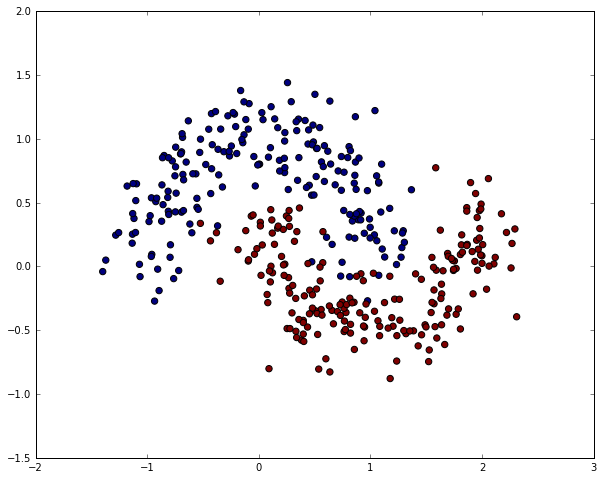

In [137]:
X2, y2 = sklearn.datasets.make_moons(400, noise=0.20)
plt.scatter(X2[:,0], X2[:,1], s=40, c=y2)

In [138]:
# Predicting on this dataset and checking the accuracy
test_predictions = ann.predict(X2,0.5)
print ann.accuracy(test_predictions, y2)

0.9575


Woah !!That's 95.75 % accuracy. But is there a way to increase the accuracy. Lets play with the number of hidden units and see how the accuracy changes.

In [145]:
hidden_layer_dimensions = [1, 3, 5, 10, 20]
for n_dim in hidden_layer_dimensions:
    ann_test = ANN(2,n_dim,1)
    ann_test.train(zip(X,y),200,0.5,0.1,show_error= False)
    predictions = ann_test.predict(X, 0.5)
    accuracy = ann_test.accuracy(predictions, y)
    print 'Training accuracy with %d hidden units %f' % (n_dim,accuracy)

Final training squared error 19.40
Training accuracy with 1 hidden units 0.882500
Final training squared error 18.59
Training accuracy with 3 hidden units 0.885000
Final training squared error 5.61
Training accuracy with 5 hidden units 0.960000
Final training squared error 5.54
Training accuracy with 10 hidden units 0.960000
Final training squared error 5.65
Training accuracy with 20 hidden units 0.957500


Here, we can observe that the accuracy didnt increase beyond 96% even with the increase in the number of hidden units. But the accuracy was less with 1 or 3 hidden units. By this we can infer that the number of hidden units may not matter after some point, in this case its around 5 units. 

Lets now also play with the number of iterations for a network with 5 hidden units and see its impact on accuracy.

In [146]:
no_iterations = [50, 120, 200, 300, 400]
for n_iter in no_iterations:
    ann_test = ANN(2,5,1)
    ann_test.train(zip(X,y),n_iter,0.5,0.1,show_error= False)
    predictions = ann_test.predict(X, 0.5)
    accuracy = ann_test.accuracy(predictions, y)
    print 'Training accuracy with %d iterations %f' % (n_iter,accuracy)

Final training squared error 18.57
Training accuracy with 50 iterations 0.877500
Final training squared error 6.83
Training accuracy with 120 iterations 0.955000
Final training squared error 5.59
Training accuracy with 200 iterations 0.960000
Final training squared error 5.18
Training accuracy with 300 iterations 0.965000
Final training squared error 5.06
Training accuracy with 400 iterations 0.967500


The error decreased with the increase in the number of iterations with 96.75% accuracy for 400 iterations. Though, it decreased it is not advisable to run it for high number of iterations becuase of overfitting. For problems with large number of features, we may have to run for even large number of iterations. 

There are many other parameters that can be tweaked like number of hidden layers, learning rates, Momentum factors etc. Feel free to experiment with them. Hope you had a great start with understanding Neural networks. Have fun !! May the Global Minimum be with you !! :)

Cheers!  
## Akash Veeragouni